# Plotting jets as images

In [2]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

import copy

In [ ]:
def rotate_to_leading_subjet(jetparticles,Jets):
    
    rotated = copy.copy(jetparticles)
    
    subjet0leading = Jets.jet_subjet0_pt > Jets.jet_subjet1_pt
    centroid1_pt = np.where( subjet0leading, Jets.jet_subjet0_pt, Jets.jet_subjet1_pt  )
    centroid1_eta = np.where( subjet0leading, Jets.jet_subjet0_eta, Jets.jet_subjet1_eta  )
    centroid1_phi = np.where( subjet0leading, Jets.jet_subjet0_phi, Jets.jet_subjet1_phi  )
    centroid1_m = np.where( subjet0leading, Jets.jet_subjet0_m, Jets.jet_subjet1_m  )
    centroid2_pt = np.where( subjet0leading, Jets.jet_subjet1_pt, Jets.jet_subjet0_pt,   )
    centroid2_eta = np.where( subjet0leading, Jets.jet_subjet1_eta, Jets.jet_subjet0_eta  )
    centroid2_phi = np.where( subjet0leading, Jets.jet_subjet1_phi, Jets.jet_subjet0_phi  )
    centroid2_m = np.where( subjet0leading, Jets.jet_subjet1_m, Jets.jet_subjet0_m  )
    
    centroid1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid1_pt, centroid1_eta, centroid1_phi, centroid1_m )
    centroid2 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid2_pt, centroid2_eta, centroid2_phi, centroid2_m )

    
    ## Now we do the rotations here: 

    return rotated
    

In [3]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            jet_subjet0_pt=df['jet_subjet0_pt'],
            jet_subjet0_eta=df['jet_subjet0_eta'],
            jet_subjet0_phi=df['jet_subjet0_phi'],
            jet_subjet0_m=df['jet_subjet0_m'],
            jet_subjet1_pt=df['jet_subjet1_pt'],
            jet_subjet1_eta=df['jet_subjet1_eta'],
            jet_subjet1_phi=df['jet_subjet1_phi'],
            jet_subjet1_m=df['jet_subjet1_m'],
            )        
        particles = JaggedCandidateArray.candidatesfromcounts(
            df['nGen'],
            pt=df['gen_pt'],
            eta=df['gen_eta'],
            phi=df['gen_phi'],
            mass=df['gen_m'],
            pdgid=df['gen_id'],
            status=df['gen_status']
            )
        
        
        finalpart_index = (particles.status == 84)
        particles = particles[finalpart_index]
        output['cutflow']['all events'] += Jets.size

        twoJets = (Jets.counts >= 2)
        Jets = Jets[twoJets]
        particles = particles[twoJets]
        output['cutflow']['>=2 jets'] += twoJets.sum()
        #print('Jets.shape ', Jets.shape)
        
        
        #pairing = particles.p4.cross(Jets.p4[:,0], nested=True)
        #print("pairing.shape ", pairing.shape)
        metric = particles.p4.delta_r(Jets.p4[:,0])
        #print("metric.shape ", metric.shape )
        dr_cut = (metric < 0.8)
        
        jetparticles = particles[dr_cut]
        #rotatedparticles = rotate_to_leading_subjet(jetparticles,Jets)
        #print('jetparticles: ', jetparticles)
        
        output['pt'].fill(dataset=dataset,
                            pt=Jets.pt.flatten())
        output['eta'].fill(dataset=dataset, 
                                 eta=Jets.eta.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:


fileset={
    'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addsubstructure.root'],
    'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addsubstructure.root'],
    'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addsubstructure.root'],
    #'QCD':'/mnt/data/ml/qcd_flat15to7000_addsubstructure.root'
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 1, 'flatten': True},
                                  chunksize=50000,
                                  
                                 )


elapsed = time.time() - tstart
print(output)

Processing: 100%|██████████| 6/6 [01:20<00:00, 13.35s/items]

{'pt': <Hist (dataset,pt) instance at 0x7f1ed75b0a58>, 'eta': <Hist (dataset,eta) instance at 0x7f1e9c591710>, 'cutflow': defaultdict(<class 'int'>, {'all events': 299632, '>=2 jets': 291180})}


In [5]:
import matplotlib.pyplot as plt

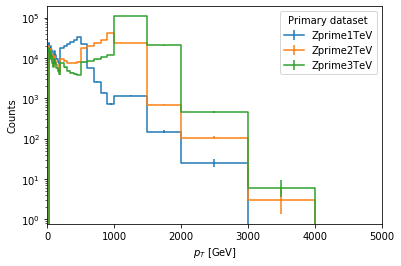

In [6]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

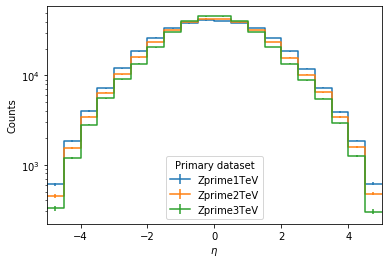

In [7]:
fig, ax = hist.plotgrid(output['eta'], overlay="dataset", stack=False
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

In [8]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 3738.201931622532
